In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from itertools import combinations
from tensorflow.keras.callbacks import Callback
import tensorflow_probability as tfp


In [54]:
config = {
    'epochs': 50,
    'batch_size': 128,
    'learning_rate': 0.001,
    'scheduler_alpha': 0.02,
    'activation': 'gelu',
    'dropout_rate': 0.3,
    'val_size': 0.2,
}

# Data Loader

In [55]:

def sample_m_shape_beta():
    # 50% 機率選左側（偏小），50% 選右側（偏大）
    if tf.random.uniform([]) < 0.5:
        lam = tfp.distributions.Beta(3, 20.0).sample()
    else:
        lam = 1.0 - tfp.distributions.Beta(3, 20.0).sample()
    return lam

def mixup_tf(x, y):
    lam = sample_m_shape_beta()
    index = tf.random.shuffle(tf.range(tf.shape(x)[0]))
    x_mix = lam * x + (1.0 - lam) * tf.gather(x, index)
    y_mix = lam * y + (1.0 - lam) * tf.gather(y, index)
    return x_mix, y_mix

# def mixup_tf(x, y, alpha=1):
#     lam = tfp.distributions.Beta(alpha, alpha).sample()
#     index = tf.random.shuffle(tf.range(tf.shape(x)[0]))
#     x_mix = lam * x + (1 - lam) * tf.gather(x, index)
#     y_mix = lam * y + (1 - lam) * tf.gather(y, index)
#     return x_mix, y_mix

In [56]:
file_dir = './radar_data/special/'
# training data
# input
mat = sio.loadmat(file_dir + 'train_Covariance.mat')
train_input = mat['Covariance']
train_input = np.float32(train_input)
# print("train_input shape:", train_input.shape)

# output
mat = sio.loadmat(file_dir + 'train_Label.mat')
train_output_old = mat['Label']
train_output_old = np.float32(train_output_old)
train_output = train_output_old

dataset = tf.data.Dataset.from_tensor_slices((train_input, train_output))
# print orginal number of samples in train_dataset
num_samples_train_org = sum(1 for _ in dataset)
print("Original number of samples in train_dataset:", num_samples_train_org)

# train_dataset = (
#     dataset
#     .shuffle(buffer_size=1000)
#     .batch(config['batch_size'])
#     .map(mixup_tf, num_parallel_calls=tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

# Mixup 的資料集（先 shuffle 才 batch 才 mix）
mix_dataset = (
    dataset
    .shuffle(num_samples_train_org)  # shuffle before batching
    .batch(config['batch_size'])
    .map(mixup_tf, num_parallel_calls=tf.data.AUTOTUNE)
    .unbatch()  # 重要！把 mixup 的 batch 還原，才能與原始資料合併
)
# # 輸出 mix_dataset 的label example
# for batch in mix_dataset.take(5):
#     mix_input, mix_output = batch
#     print("Mixup output:", mix_output)


# 合併原始與 mix 資料
combined_dataset = dataset.concatenate(mix_dataset).shuffle(num_samples_train_org * 2)

# for batch in combined_dataset.take(10):
#     input_example, output_example = batch
#     print("Combined output example:", output_example)



# 將 validation 資料從原始資料中移除
# train_dataset = combined_dataset.skip(int(num_samples_train_org * config['val_size']))

train_dataset = (
    combined_dataset
    .batch(config['batch_size'])
    .prefetch(tf.data.AUTOTUNE)
)
    
# print("train_dataset.shape:", train_dataset.element_spec)
# print number of samples in train_dataset
total_samples_train = sum(batch[0].shape[0] for batch in train_dataset)
print("Total number of training samples (after batching):", total_samples_train)



# testing data
# input
mat = sio.loadmat(file_dir + 'test_Covariance.mat')
test_input = mat['Covariance']
test_input = np.float32(test_input)
# print("test_input shape:", test_input.shape)

# output
mat = sio.loadmat(file_dir + 'test_Label.mat')
test_output_old = mat['Label']
test_output_old = np.float32(test_output_old)
test_output = test_output_old

dataset = tf.data.Dataset.from_tensor_slices((test_input, test_output))
test_dataset = dataset.batch(config['batch_size']).prefetch(tf.data.AUTOTUNE)

# print("test_output shape:", test_output.shape)
# print("test_dataset.shape:", test_dataset.element_spec)
# print number of samples in test_dataset
total_samples_test = sum(batch[0].shape[0] for batch in test_dataset)
print("Total number of testing samples (after batching):", total_samples_test)

Original number of samples in train_dataset: 57344
Total number of training samples (after batching): 114688
Total number of testing samples (after batching): 14336


# model

In [57]:
input_layer = Input(shape=(train_input.shape[1], train_input.shape[2], 2))
# sc = layers.Conv2D(128, (1,1), padding='same')(input_layer)
x = layers.Conv2D(128, (3, 3), padding='same')(input_layer)
x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
x = layers.Activation(config['activation'])(x)

# shortcut = layers.Conv2D(1024, (1, 1), padding='same')(x)
# # shortcut = layers.AveragePooling2D((8, 8))(shortcut)
# shortcut = layers.MaxPooling2D((8, 8))(shortcut)
# shortcut = layers.BatchNormalization()(shortcut)
# # shortcut = layers.LeakyReLU()(shortcut)
# shortcut = layers.Activation(config['activation'])(shortcut)

x = layers.Conv2D(128, (3, 3), padding='same')(x)
# x = layers.Add()([x, sc])
# x = layers.AveragePooling2D((2, 2))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
x = layers.Activation(config['activation'])(x)
# sc = layers.Conv2D(256, (1,1), padding='same')(x)
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
x = layers.Activation(config['activation'])(x)

x = layers.Conv2D(256, (3, 3), padding='same')(x)
# x = layers.Add()([x, sc])
# x = layers.AveragePooling2D((2, 2))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
x = layers.Activation(config['activation'])(x)
# sc = layers.Conv2D(512, (1,1), padding='same')(x)
x = layers.Conv2D(512, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
x = layers.Activation(config['activation'])(x)

x = layers.Conv2D(512, (3, 3), padding='same')(x)
# x = layers.Add()([x, sc])
# 這裡的 pooling 改成 MaxPooling2D
x = layers.AveragePooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
x = layers.Activation(config['activation'])(x)
x = layers.Conv2D(1024, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
x = layers.Activation(config['activation'])(x)

x = layers.Conv2D(1024, (3, 3), padding='same')(x)
# x = layers.Add()([x, shortcut])
x = layers.AveragePooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
x = layers.Activation(config['activation'])(x)
x = layers.Conv2D(1024, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
x = layers.Activation(config['activation'])(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256)(x)    
x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
x = layers.Activation(config['activation'])(x)
x = layers.Dropout(config['dropout_rate'])(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
x = layers.Activation(config['activation'])(x)
x = layers.Dropout(config['dropout_rate'])(x)
output_layer = layers.Dense(train_output.shape[1], activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 128)       2432      
                                                                 
 batch_normalization_44 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 activation_44 (Activation)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                       

In [58]:
# model = keras.Sequential([
#     keras.layers.Conv2D(128, (3, 3), input_shape=(train_input.shape[1], train_input.shape[2], 2)),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(alpha=0.3),
#     keras.layers.Conv2D(128, (3, 3), padding='same'),
#     keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(alpha=0.3),
    
#     keras.layers.Conv2D(256, (3, 3), padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(alpha=0.3),
#     keras.layers.Conv2D(256, (3, 3), padding='same'),
#     keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(alpha=0.3),
    
#     keras.layers.Conv2D(512, (3, 3), padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(alpha=0.3),
#     keras.layers.Conv2D(512, (3, 3), padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(alpha=0.3),
    
#     keras.layers.Conv2D(1024, (3, 3), padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(alpha=0.3),
#     keras.layers.Conv2D(1024, (3, 3), padding='same'),
#     keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(alpha=0.3),
    
#     keras.layers.GlobalAveragePooling2D(),
    
#     keras.layers.Dense(512),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(alpha=0.3),
#     keras.layers.Dropout(config['dropout_rate']),
#     keras.layers.Dense(1024),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(alpha=0.3),
#     keras.layers.Dropout(config['dropout_rate']),
#     keras.layers.Dense(128),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(alpha=0.3),
#     keras.layers.Dropout(config['dropout_rate']),
#     keras.layers.Dense(train_output.shape[1]),
#     keras.layers.Activation('sigmoid'),
# ])

# model.summary()

In [59]:
def top2_postprocess(y_pred):
    y_out = np.zeros_like(y_pred)
    top2_idx = np.argsort(y_pred, axis=1)[:, -2:]
    for i in range(len(y_pred)):
        y_out[i, top2_idx[i]] = 1
    return y_out

def exact_match_accuracy(y_true, y_pred):    
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
    # top 2
    # y_pred_binary = top2_postprocess(y_pred.numpy())

    y_true_binary = tf.cast(y_true > 0.5, tf.float32)  # 確保 y_true 也是 float32
    
    # 比對是否逐 row 全部正確
    match = tf.reduce_all(tf.equal(y_true_binary, y_pred_binary), axis=1)

    # 計算準確率
    accuracy = tf.reduce_mean(tf.cast(match, tf.float32))
    
    return accuracy

In [60]:
def combination_loss(lambda_constraint=1):
    def loss_fn(y_true, y_pred):
        # 二進制交叉熵損失
        # bce_loss = keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
        bce_loss = tf.reduce_mean(keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False))
        
        # 約束：只有兩個正數
        positive_count = tf.reduce_sum(y_pred, axis=1)
        # positive_count = tf.reduce_sum(tf.cast(probs > 0.5, tf.float32), axis=1)  # 每行正數的個數
        sum_constraint = tf.reduce_mean(tf.square(positive_count - 2.0))  # 平均每行正數個數與2的差的平方
        # sum_constraint = tf.reduce_mean(tf.square(tf.reduce_sum(y_pred, axis=1) - 2.0))
        
        # 總損失
        total_loss = bce_loss + lambda_constraint * sum_constraint
        return total_loss
    
    return loss_fn

In [61]:
class PositiveCountMonitor(Callback):
    def __init__(self, test_dataset):
        super().__init__()
        self.test_dataset = test_dataset  # tf.data.Dataset 格式

    def on_epoch_end(self, epoch, logs=None):
        pos_counts = []

        for batch in self.test_dataset:
            x_batch, _ = batch
            y_pred = self.model.predict(x_batch, verbose=0)
            binary_preds = tf.cast(y_pred > 0.5, tf.float32)
            batch_pos_counts = tf.reduce_sum(binary_preds, axis=1).numpy()  # 每個樣本正例數
            pos_counts.extend(batch_pos_counts)

        pos_counts = np.array(pos_counts)
        avg_pos = np.mean(pos_counts)
        std_pos = np.std(pos_counts)

        print(f'\n[monitor] Epoch {epoch+1}: Average positive count: {avg_pos:.2f}, Std: {std_pos:.2f}')

In [62]:
# from tensorflow.keras.optimizers.sche dules import CosineDecay
# lr_schedule = CosineDecay(initial_learning_rate=config['learning_rate'], decay_steps=config['epochs'] * (total_samples_train // config['batch_size']), alpha=config['scheduler_alpha'])

# lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
#     initial_learning_rate = config['learning_rate'],
#     decay_steps = config['epochs'] * (total_samples_train // config['batch_size']),
#     end_learning_rate = 1e-5,  # 最終學習率
#     power=1.5  # power=1 就是線性下降
# )
# --- 基本參數 ---
initial_learning_rate = config['learning_rate']         # 例如 1e-3
end_learning_rate = 1e-5                                 # 最終學習率
warmup_epochs = 5                                        # 預熱階段（你可自行調整）
total_epochs = config['epochs']
steps_per_epoch = total_samples_train // config['batch_size']
total_steps = total_epochs * steps_per_epoch
warmup_steps = warmup_epochs * steps_per_epoch

# --- Polynomial Decay 主體 ---
poly_lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=total_steps - warmup_steps,
    end_learning_rate=end_learning_rate,
    power=1.5
)

# --- 包裝成 WarmUp + PolynomialDecay ---
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps, after_schedule):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.after_schedule = after_schedule

    def __call__(self, step):
        # 預熱階段：線性從 0 增加到 initial_lr
        warmup_lr = self.initial_lr * (tf.cast(step, tf.float32) / tf.cast(self.warmup_steps, tf.float32))
        # 預熱後，走 polynomial decay
        return tf.cond(step < self.warmup_steps, lambda: warmup_lr, lambda: self.after_schedule(step - self.warmup_steps))

# 建立學習率 schedule
lr_schedule = WarmUp(
    initial_lr=initial_learning_rate,
    warmup_steps=warmup_steps,
    after_schedule=poly_lr_schedule
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])


model.compile(optimizer = optimizer,
              # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
            #   loss = combination_loss(lambda_constraint = 0.5),
              metrics = [exact_match_accuracy])

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_exact_match_accuracy', factor=0.5, patience=5, min_lr=1e-6
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_exact_match_accuracy', mode='max', patience=10, restore_best_weights=True
)

monitor = PositiveCountMonitor(train_dataset)

In [63]:
class LrLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
        print(f"\nEpoch {epoch + 1}: Learning rate is {lr:.6f}")

In [64]:
# history = model.fit(train_dataset, validation_data=test_dataset, epochs=config['epochs'], batch_size=config['batch_size'], callbacks=[lr_scheduler, early_stopping, monitor], verbose=1)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=config['epochs'], batch_size=config['batch_size'], verbose=1)
# history = model.fit(train_input, train_output, epochs=config['epochs'], batch_size=config['batch_size'], validation_split=0.2, callbacks=[lr_scheduler, early_stopping, monitor], verbose=1)

Epoch 1/50
896/896 [==============================] - 91s 99ms/step - loss: 0.3606 - exact_match_accuracy: 0.5182 - val_loss: 0.2470 - val_exact_match_accuracy: 0.5195
Epoch 2/50
896/896 [==============================] - 89s 99ms/step - loss: 0.1259 - exact_match_accuracy: 0.9499 - val_loss: 0.1765 - val_exact_match_accuracy: 0.6489
Epoch 3/50
896/896 [==============================] - 89s 99ms/step - loss: 0.1119 - exact_match_accuracy: 0.9608 - val_loss: 0.2892 - val_exact_match_accuracy: 0.5546
Epoch 4/50
896/896 [==============================] - 89s 99ms/step - loss: 0.1098 - exact_match_accuracy: 0.9647 - val_loss: 0.1973 - val_exact_match_accuracy: 0.6743
Epoch 5/50
896/896 [==============================] - 89s 99ms/step - loss: 0.1039 - exact_match_accuracy: 0.9700 - val_loss: 0.2855 - val_exact_match_accuracy: 0.6828
Epoch 6/50
896/896 [==============================] - 89s 99ms/step - loss: 0.1037 - exact_match_accuracy: 0.9739 - val_loss: 0.1908 - val_exact_match_accuracy:

KeyboardInterrupt: 

# Training result

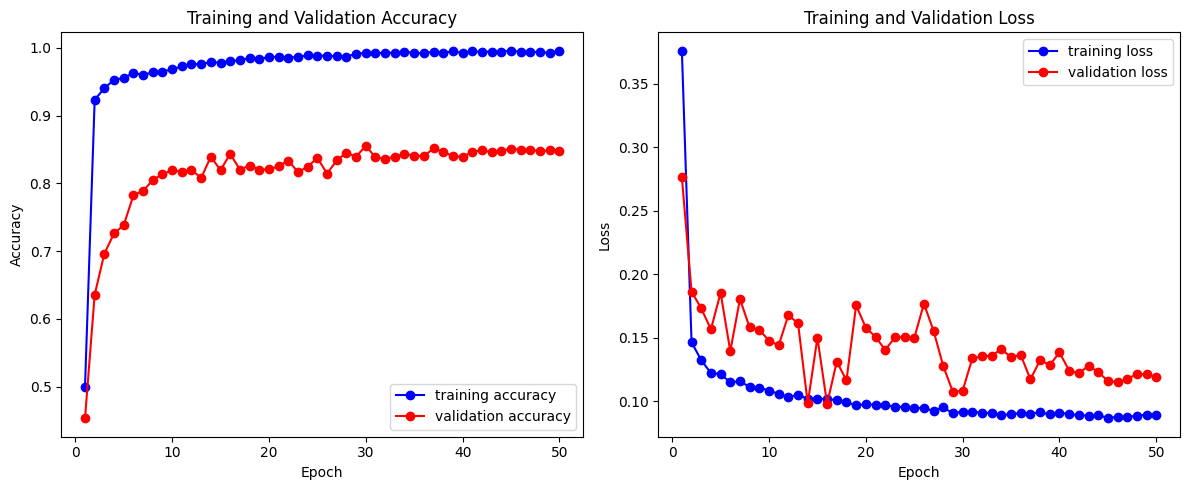

In [ ]:

# 取出歷史紀錄
# acc = history.history['accuracy']
acc = history.history['exact_match_accuracy']
val_acc = history.history['val_exact_match_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# 畫準確率
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 畫損失
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='training loss')
plt.plot(epochs, val_loss, 'ro-', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test

In [ ]:
model.evaluate(test_dataset, verbose=1)

112/112 [==============================] - 3s 30ms/step - loss: 0.1190 - exact_match_accuracy: 0.8480


[0.1189742460846901, 0.8480049967765808]

In [ ]:
predictions = model.predict(test_input)
# print('\nPredictions shape:', predictions.shape)
predictions_threshold = (predictions > 0.5).astype(np.float32)  # 將概率轉換為二進制輸出
predictions_top2 = top2_postprocess(predictions)  # 將預測結果轉換為 top-2 的 one-hot 編碼
# print('predictions:', predictions[0:10])  # 顯示前10筆預測結果

sum_is_not_2_cnt = 0
accuracy_thresold = 0
for pred, label in zip(predictions_threshold, test_output):
    # print('Predicted:', pred, 'True:', label)
    accuracy_thresold += (pred == label).all()
    if np.sum(pred) != 2:
        sum_is_not_2_cnt += 1

accuracy_thresold /= len(predictions)

accuracy_top2 = 0
for pred, label in zip(predictions_top2, test_output):
    # print('Predicted:', pred, 'True:', label)
    accuracy_top2 += (pred == label).all()

accuracy_top2 /= len(predictions)
        
print('\nExact Match Accuracy:', accuracy_thresold)
print('Top-2 Exact Match Accuracy:', accuracy_top2)

print('Number of predictions not summing to 2:', sum_is_not_2_cnt)
print('Number of prediction summing to 2 ratio:', (len(predictions) - sum_is_not_2_cnt) / len(predictions))


448/448 [==============================] - 4s 8ms/step

Exact Match Accuracy: 0.8480050223214286
Top-2 Exact Match Accuracy: 0.9006696428571429
Number of predictions not summing to 2: 1416
Number of prediction summing to 2 ratio: 0.9012276785714286


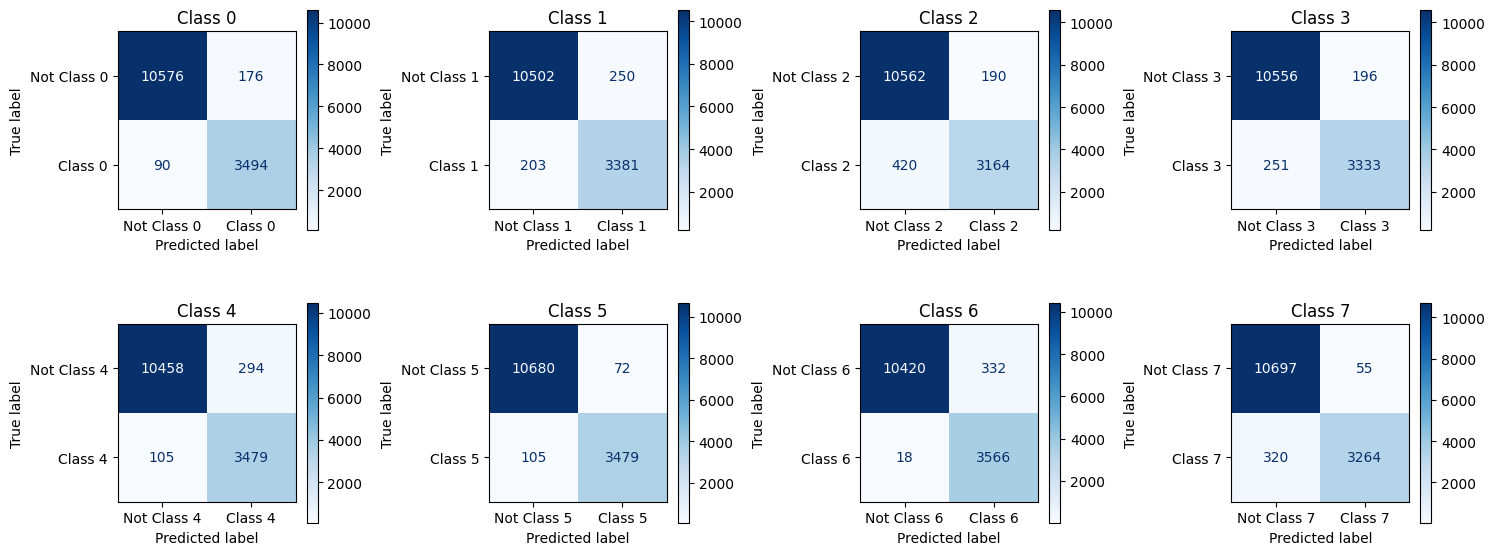

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# y_true, y_pred 是多標籤格式，例如：
# y_true = np.array([[1, 0, 0, 1, 0, 0, 0, 0], [...], ...])
# y_pred = np.array([[1, 0, 1, 0, 0, 0, 0, 0], [...], ...])

# 計算每個類別的混淆矩陣
cm = multilabel_confusion_matrix(test_output, predictions_threshold)

# 類別名稱（可以自己命名）
class_names = [f"Class {i}" for i in range(test_output.shape[1])]

# 畫出每個類別的混淆矩陣
fig, axes = plt.subplots(2, (len(class_names)+1)//2, figsize=(15, 6))
axes = axes.ravel()

for i in range(len(class_names)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i],
                                   display_labels=["Not "+class_names[i], class_names[i]])
    disp.plot(ax=axes[i], values_format='d', cmap='Blues')
    axes[i].set_title(class_names[i])

plt.tight_layout()
plt.show()
